In [ ]:
# Usaremos una base de datos de imágenes con dos clases: perros y gatos.

# El objetivo es diseñar redes neuronales de convolución para clasificar perros 
# de gatos. Este problema es mucho más complejo que los anteriores, ya que:
# 1) las características visuales que comparten perros y gatos pueden ser altas;
# y 2) las imágenes pueden contener background común. Estas dos características
# hace difícil separa las imágenes.

# También probaremos una función de utilidad de tensorflow, con la cual no 
# necesitamos cargar todos los datos en memoria al mismo tiempo, sino que los 
# vamos cargando por lote (al vuelo). Con la ventaja adicional de que podemos
# crear variaciones sintéticas de ellos.

# Finalmente, veremos otras dos aplicaciones de CNN's

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

# Part 1: Download data and set directories

In [ ]:
# Download data from a website
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# List path contents
!ls $PATH

68616192/68606236 [==============================] - 0s 0us/step
train  validation  vectorize.py


In [ ]:
# Define paths to training and validation images
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'validation')

# Specify them by class
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with training dog pictures
val_cats_dir = os.path.join(val_dir, 'cats')      # directory with validation cat pictures
val_dogs_dir = os.path.join(val_dir, 'dogs')      # directory with validation dog pictures

# Print example
print(train_cats_dir)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [ ]:
# Count how many of them are there
n_cats_train = len(os.listdir(train_cats_dir))
n_dogs_train = len(os.listdir(train_dogs_dir))

n_cats_val = len(os.listdir(val_cats_dir))
n_dogs_val = len(os.listdir(val_dogs_dir))

n_total_train = n_cats_train + n_dogs_train
n_total_val = n_cats_val + n_dogs_val

# Print some info
print('total training cat images:', n_cats_train)
print('total training dog images:', n_dogs_train)

print('total validation cat images:', n_cats_val)
print('total validation dog images:', n_dogs_val)
print("--")
print("Total training images:", n_total_train)
print("Total validation images:", n_total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:
# No data has been loaded yet
%whos

Variable             Type      Data/Info
----------------------------------------
BatchNormalization   type      <class 'keras.layers.norm<...>tion.BatchNormalization'>
Conv2D               type      <class 'keras.layers.convolutional.Conv2D'>
Dense                type      <class 'keras.layers.core.dense.Dense'>
Dropout              type      <class 'keras.layers.core.dropout.Dropout'>
Flatten              type      <class 'keras.layers.core.flatten.Flatten'>
ImageDataGenerator   type      <class 'keras.preprocessi<...>mage.ImageDataGenerator'>
InputLayer           type      <class 'keras.engine.input_layer.InputLayer'>
LeakyReLU            type      <class 'keras.layers.adva<...>d_activations.LeakyReLU'>
MaxPooling2D         type      <class 'keras.layers.pooling.MaxPooling2D'>
PATH                 str       /root/.keras/datasets/cats_and_dogs_filtered
Sequential           type      <class 'keras.engine.sequential.Sequential'>
UpSampling2D         type      <class 'keras.layers.convo

# Part 2: Define data generators

In [ ]:
# Define some constants
batch_size = 64
IMG_H = 128
IMG_W = 128

In [ ]:
# Define generator objects for training and validation data.
# Generator objects will include controlled noise

# With added noise
#train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15,
#                                   width_shift_range=0.15, height_shift_range=0.15,
#                                   zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
#                                   featurewise_center=True, samplewise_center=True,
#                                   featurewise_std_normalization=True, samplewise_std_normalization=True)
#val_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15,
#                                 width_shift_range=0.15, height_shift_range=0.15,
#                                 zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
#                                 featurewise_center=True, samplewise_center=True,
#                                 featurewise_std_normalization=True, samplewise_std_normalization=True)

# Without noise (rescale is still need it, as pixel values have integer values
# between 0 and 255. after rescaling them, they have real values between 0 and 1).
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_H, IMG_W),
                                                class_mode='binary')
val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_H, IMG_W),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# No data is been loaded yet
%whos

Variable             Type                  Data/Info
----------------------------------------------------
BatchNormalization   type                  <class 'keras.layers.norm<...>tion.BatchNormalization'>
Conv2D               type                  <class 'keras.layers.convolutional.Conv2D'>
Dense                type                  <class 'keras.layers.core.dense.Dense'>
Dropout              type                  <class 'keras.layers.core.dropout.Dropout'>
Flatten              type                  <class 'keras.layers.core.flatten.Flatten'>
IMG_H                int                   128
IMG_W                int                   128
ImageDataGenerator   type                  <class 'keras.preprocessi<...>mage.ImageDataGenerator'>
InputLayer           type                  <class 'keras.engine.input_layer.InputLayer'>
LeakyReLU            type                  <class 'keras.layers.adva<...>d_activations.LeakyReLU'>
MaxPooling2D         type                  <class 'keras.layers.poolin

(64, 128, 128, 3)
0.0
1.0
(64,)


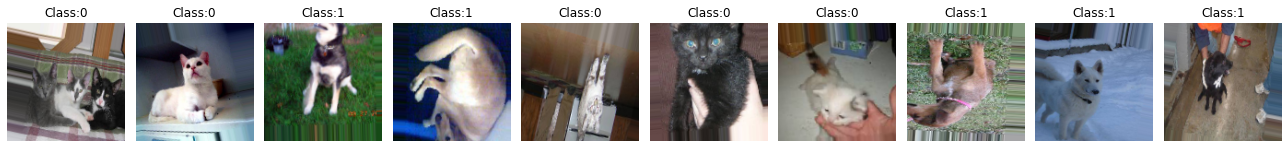

In [ ]:
# This cell is just an example of a batch returned by the data generator
# The 'next()' function returns a batch from the dataset
sample_x, sample_y = next(train_generator)
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)

# Show a few of them
fig, axes = plt.subplots(1, 10, figsize=(18, 5))
axes = axes.flatten()
for ind, (img, ax) in enumerate(zip(sample_x[:10], axes)):
  ax.imshow(img)
  ax.set_title("Class:" + str(int(sample_y[ind])))
  ax.axis('off')
plt.tight_layout()
plt.show()

# Part 3: Create CNN model and train it

In [39]:
# == Q1 ==
# Diseña una red CNN
# ¿Puedes lograr exactitud >= 0.8 en el set de validación?
# ¿Cuál es la pérdida asociada?
# ¿Cuántos parámetros tiene tu modelo?
# ¿Qué otros hiper-parámetros definiste?

In [ ]:
# Create a CNN
CNN = Sequential([
    InputLayer(input_shape=(IMG_H, IMG_W, 3)),
    
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Conv2D(64, 3, activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 64)      

In [ ]:
# Compile: Define training parameters
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train model
EPOCHS = 10
BATCHES = n_total_train//batch_size

CNN.fit(train_generator, steps_per_epoch=BATCHES, epochs=EPOCHS, validation_data=val_generator)

Epoch 1/10
31/31 [==============================] - 105s 3s/step - loss: 0.6954 - accuracy: 0.4954 - val_loss: 0.7251 - val_accuracy: 0.5000
Epoch 2/10
31/31 [==============================] - 102s 3s/step - loss: 0.6996 - accuracy: 0.4757 - val_loss: 0.6928 - val_accuracy: 0.5650
Epoch 3/10
31/31 [==============================] - 103s 3s/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6925 - val_accuracy: 0.5740
Epoch 4/10
31/31 [==============================] - 104s 3s/step - loss: 0.6929 - accuracy: 0.5217 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 5/10
31/31 [==============================] - 101s 3s/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.6928 - val_accuracy: 0.4990
Epoch 6/10
31/31 [==============================] - 104s 3s/step - loss: 0.6930 - accuracy: 0.4849 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 7/10
31/31 [==============================] - 109s 4s/step - loss: 0.6899 - accuracy: 0.5248 - val_loss: 0.6909 - val_accuracy: 0.5690
Epoch 8/10
31

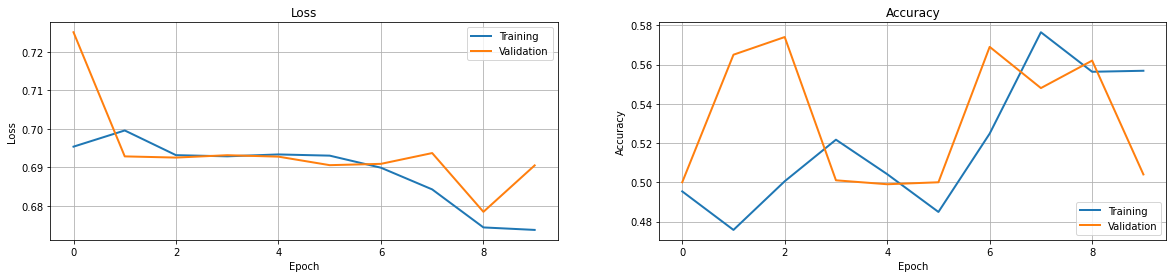

In [ ]:
# Plot loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(CNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(CNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(CNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()

# Part 4: Images as vectors

In [ ]:
# Define generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define method to load images from disk, apply rescaling, and resize them into specified size.
train_generator = train_datagen.flow_from_directory(batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_H, IMG_W),
                                                class_mode='binary')
val_generator = val_datagen.flow_from_directory(batch_size=batch_size,
                                            directory=val_dir,
                                            target_size=(IMG_H, IMG_W),
                                            class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# Get a batch sample, just to see its shape
sample_x, sample_y = next(train_generator)
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)

sample_x = np.reshape(sample_x, newshape=(len(sample_x), -1))
print(sample_x.shape)
print(sample_x.min())
print(sample_x.max())
print(sample_y.shape)

(64, 128, 128, 3)
0.0
1.0
(64,)
(64, 49152)
0.0
1.0
(64,)


In [ ]:
# == Q2 ==
# Create MLP (only perceptrons) and repeat training
# Try to get your MLP with as many parameters as your best previous CNN
# ¿Puedes lograr exactitud >= 0.8 en el set de validación?
# ¿Cuál es la pérdida asociada?
# ¿Cuántos parámetros tiene tu modelo?
# ¿Qué otros hiper-parámetros definiste?

DNN = Sequential([
    InputLayer(input_shape=(49152,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

DNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                1572896   
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,572,929
Trainable params: 1,572,929
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile: Define training parameters
DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Training code, step by step
EPOCHS = 10
BATCHES = n_total_train//batch_size
for e in range(EPOCHS):
  print(f'Epoch: {e+1:2d}', end='[')
  for batch in range(BATCHES):
    x_batch, y_batch = next(train_generator)
    x_batch = np.reshape(x_batch, newshape=(len(x_batch), -1))
    DNN.fit(x_batch, y_batch, verbose=0)
    print('=', end='')

  # At the end of the epoch, evaluate and print performance
  # on training batch
  x_batch, y_batch = next(train_generator)
  x_batch = np.reshape(x_batch, newshape=(len(x_batch), -1))
  loss, accuracy = DNN.evaluate(x_batch, y_batch, verbose=0)
  # on validation batch
  x_val_batch, y_val_batch = next(val_generator)
  x_val_batch = np.reshape(x_val_batch, newshape=(len(x_val_batch), -1))
  val_loss, val_accuracy = DNN.evaluate(x_val_batch, y_val_batch, verbose=0)
  # print
  print(f"] - loss: {loss:.4f} - accuracy: {accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

Epoch:   0[ ===============================] - loss: 0.6932 - accuracy: 0.4844 - val_loss: 0.6933 - val_accuracy: 0.4062
Epoch:   1[ ===============================] - loss: 0.6932 - accuracy: 0.4844 - val_loss: 0.6932 - val_accuracy: 0.4219
Epoch:   2[ ===============================] - loss: 0.6930 - accuracy: 0.5469 - val_loss: 0.6931 - val_accuracy: 0.5312
Epoch:   3[ ===============================] - loss: 0.6933 - accuracy: 0.4531 - val_loss: 0.6934 - val_accuracy: 0.4062
Epoch:   4[ ===============================] - loss: 0.6931 - accuracy: 0.5312 - val_loss: 0.6930 - val_accuracy: 0.5469
Epoch:   5[ ===============================] - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4062
Epoch:   6[ ===============================] - loss: 0.6934 - accuracy: 0.4531 - val_loss: 0.6933 - val_accuracy: 0.4688
Epoch:   7[ ===============================] - loss: 0.6930 - accuracy: 0.5312 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch:   8[ ====================

# Part 5: A new type of CNN

In [6]:
from os import listdir
from os.path import join
from skimage.io import imread
from skimage.transform import resize

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
# Locate folder with dataset and check for existance of both dirs
!ls /content/drive/MyDrive/DataSets/LFW/

images	masks


In [31]:
# Set paths to load images and masks
images_path = "/content/drive/MyDrive/DataSets/LFW/images/"
masks_path = "/content/drive/MyDrive/DataSets/LFW/masks/"

In [33]:
# Load images
image_names = [f for f in listdir(images_path)]
X = np.array([resize(imread(join(images_path, f)), (128, 128)) for f in image_names])

print(X.shape)
print(X.min())
print(X.max())

(1000, 128, 128, 3)
0.0
1.0


In [34]:
# Load masks
# (Uso los mismos nombres de archivos que para las imágenes, solo cambio el
# directorio y la extension)
Y = np.array([resize(imread(join(masks_path, f[:-3]+'ppm')), (128, 128)) for f in image_names])

print(Y.shape)
print(Y.min())
print(Y.max())

(1000, 128, 128, 3)
0.0
1.0


Images


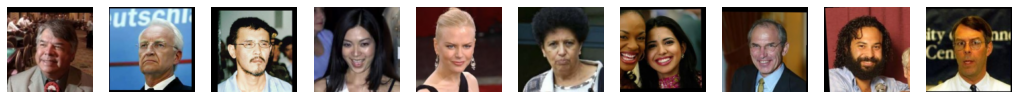

Masks


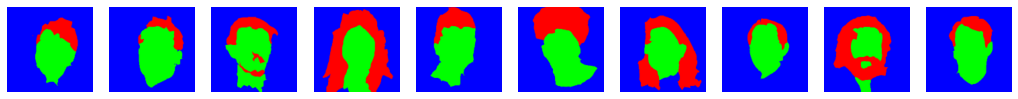

In [35]:
# Show a few examples
print("Images")
plt.figure(figsize=(18, 3))
for ind, img in enumerate(X[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()

print("Masks")
plt.figure(figsize=(18, 3))
for ind, img in enumerate(Y[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img)
  plt.axis('off')
plt.show()

In [38]:
# Split train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(900, 128, 128, 3)
(900, 128, 128, 3)
(100, 128, 128, 3)
(100, 128, 128, 3)


In [ ]:
# == Q3 ==
# Considera la siguiente CNN's
# ¿Por qué tiene 3 filtros convolucionales en el último layer?
# Revisa la documentación de tensorflow. ¿cuál es la diferencia entre el layer
# Conv2D y Con2DTranspose?
# ¿Puedes lograr exactitud >= 0.93 en el set de validación?
# ¿Cuál es la pérdida asociada?
# ¿Cuántos parámetros tiene tu modelo?
# ¿Qué otros hiper-parámetros definiste?

In [10]:
# # Lets create a CNN of type UNet
in_layer = Input(shape=(128, 128, 3))

conv1 = Conv2D(64, 3, padding='same', activation='relu')(in_layer)
conv1 = Conv2D(64, 3, padding='same', strides=2, activation='relu')(conv1)

conv2 = Conv2D(128, 3, padding='same', activation='relu')(conv1)
conv2 = Conv2D(128, 3, padding='same', strides=2, activation='relu')(conv2)

conv3 = Conv2D(256, 3, padding='same', activation='relu')(conv2)
conv3 = Conv2D(256, 3, padding='same', strides=2, activation='relu')(conv3)

conv4 = Conv2D(512, 3, padding='same', activation='relu')(conv3)

conc5 = Concatenate(axis=3)([conv4, conv3])
conv5 = Conv2DTranspose(256, 3, padding='same', strides=2, activation='relu')(conc5)
conv5 = Conv2D(256, 3, padding='same', activation='relu')(conv5)

conc6 = Concatenate(axis=3)([conv5, conv2])
conv6 = Conv2DTranspose(128, 3, padding='same', strides=2, activation='relu')(conc6)
conv6 = Conv2D(128, 3, padding='same', activation='relu')(conv6)

conc7 = Concatenate(axis=3)([conv6, conv1])
conv7 = Conv2DTranspose(64, 3, padding='same', strides=2, activation='relu')(conc7)
conv7 = Conv2D(64, 3, padding='same', activation='relu')(conv7)

out_layer = Conv2D(3, 5, padding='same', activation='sigmoid')(conv7)

UNet = Model(in_layer, out_layer)
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                              

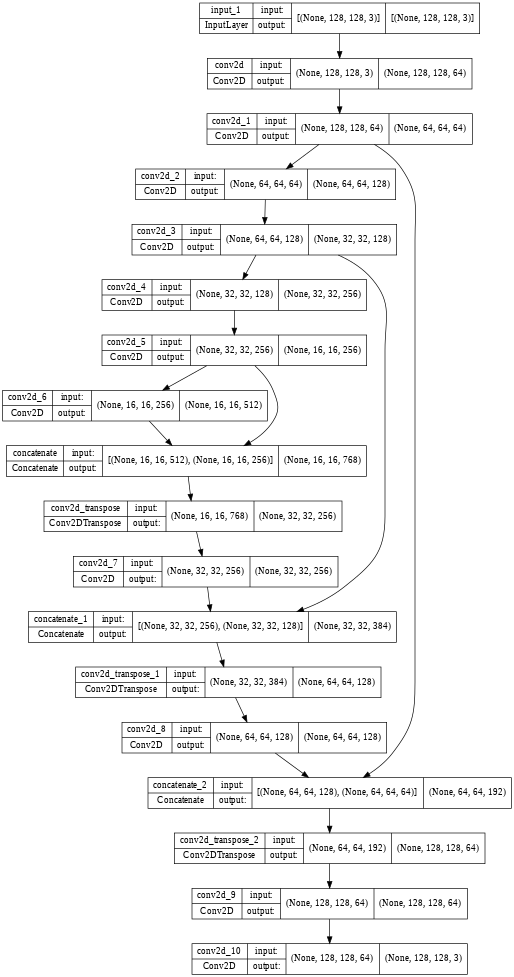

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(UNet, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=48)

In [12]:
# Compile and train it
UNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
UNet.fit(x_train, y_train, batch_size=64, epochs=30, validation_split=0.2)

Epoch 1/30
12/12 [==============================] - 30s 1s/step - loss: 0.6645 - accuracy: 0.6165 - val_loss: 0.5894 - val_accuracy: 0.6675
Epoch 2/30
12/12 [==============================] - 6s 480ms/step - loss: 0.5327 - accuracy: 0.6618 - val_loss: 0.4530 - val_accuracy: 0.6678
Epoch 3/30
12/12 [==============================] - 6s 484ms/step - loss: 0.4361 - accuracy: 0.6621 - val_loss: 0.4028 - val_accuracy: 0.6678
Epoch 4/30
12/12 [==============================] - 6s 483ms/step - loss: 0.3920 - accuracy: 0.6624 - val_loss: 0.3614 - val_accuracy: 0.7701
Epoch 5/30
12/12 [==============================] - 6s 486ms/step - loss: 0.3350 - accuracy: 0.7844 - val_loss: 0.2818 - val_accuracy: 0.8193
Epoch 6/30
12/12 [==============================] - 6s 487ms/step - loss: 0.2880 - accuracy: 0.8085 - val_loss: 0.2536 - val_accuracy: 0.8484
Epoch 7/30
12/12 [==============================] - 6s 496ms/step - loss: 0.2537 - accuracy: 0.8446 - val_loss: 0.2542 - val_accuracy: 0.8444
Epoch 8/

In [13]:
# Evaluate on test set
UNet.evaluate(x_test, y_test)

4/4 [==============================] - 3s 345ms/step - loss: 0.1475 - accuracy: 0.9115


[0.1474912017583847, 0.9115325808525085]

RGB input -- Test set


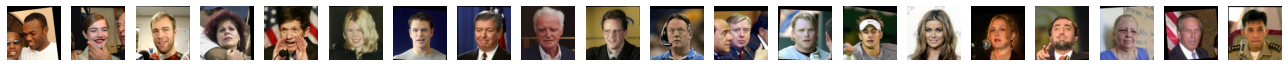

Mask output - Ground Truth -- Test set


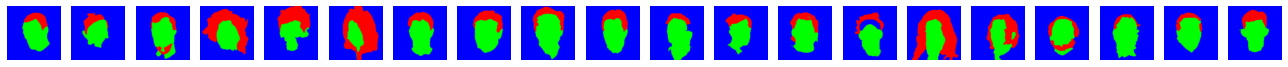

Prediction: binary -- Test set


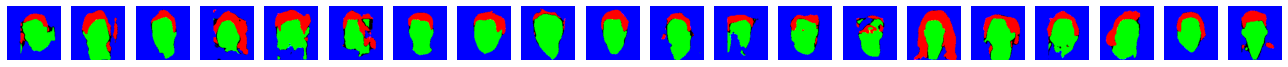

Prediction: probability -- Test set


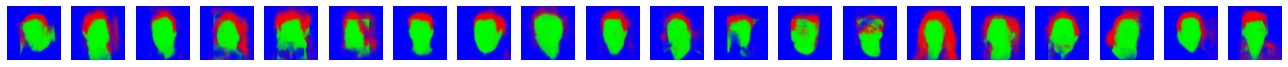

In [14]:
# Show some predictions
y_test_hat = UNet.predict(x_test)

rand_ID = np.random.randint(0, len(x_test), 20) # Rand selection of images

print("RGB input -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(x_test[rand_ID[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()

print("Mask output - Ground Truth -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(y_test[rand_ID[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()

print("Prediction: binary -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(y_test_hat[rand_ID[ind]].round())
  plt.axis('off')
plt.tight_layout()
plt.show()

print("Prediction: probability -- Test set")
plt.figure(figsize=(18, 4))
for ind in range(20):
  plt.subplot(1, 20, ind+1)
  plt.imshow(y_test_hat[rand_ID[ind]])
  plt.axis('off')
plt.tight_layout()
plt.show()

# Part 6: Yet another type of CNN

In [2]:
# Importa los dígitos MNIST
# == Q4 ==
# Revisa las celdas de esta sección.
# Explica por qué crees que, al importar las imágenes, las asignamos a una
# variable llamada 'y' (en vez de 'x' como lo hicimos en la tarea anterior).
from tensorflow.keras.datasets import mnist
(y_train, _), (y_test, _) = mnist.load_data() # puedes revisar la documentación
# de la base de datos MNIST

# Dividimos entre 255 para tener pixeles con valores entre 0 y 1.
y_train = y_train / 255.
y_test  = y_test  / 255.

# Hacemos reshape, ya que las CNN requieren conocer explícitamente el número de
# canales de las imágenes. 1 canal en caso de imágenes binarias y grises.
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
y_test  = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], y_test.shape[2], 1))

print("Shapes")
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
Shapes
y_train: (60000, 28, 28, 1)
y_test: (10000, 28, 28, 1)


In [5]:
# == Q5 ==
# Aquí defino una funión. ¿Puedes explica qué es lo que hace?
from skimage.transform import resize

def noisy_resize(img):
  img = resize(img, (7, 7))
  for row in range(7):
    for col in range(7):
      if np.random.rand() > 0.9:
        img[row, col] = np.abs(img[row, col] - 1)
  return img

In [6]:
# Ahora sí genero x (señales de entrada)
x_train = np.array([noisy_resize(img) for img in y_train])
x_test  = np.array([noisy_resize(img) for img in y_test ])

print("Shapes")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)

Shapes
x_train: (60000, 7, 7, 1)
x_test: (10000, 7, 7, 1)


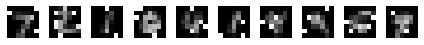

In [9]:
# Show a few examples of X
for ind, img in enumerate(x_test[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [13]:
# Create a CNN (Notice there is no InputLayer)
CNN = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(32, 3, padding='same', activation='relu'),
    UpSampling2D(),

    Conv2D(32, 3, padding='same', activation='relu'),
    Conv2D(1, 3, padding='same', activation='sigmoid'),
])

CNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 7, 7, 32)          320       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          9248      
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 32)       0         
 2D)                                                  

In [15]:
# Compile and train
CNN.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
history = CNN.fit(x=x_train, y=y_train, batch_size=64, epochs=20, validation_split=0.1)

Epoch 1/20
844/844 [==============================] - 11s 12ms/step - loss: 0.3595 - binary_accuracy: 0.8047 - val_loss: 0.2411 - val_binary_accuracy: 0.7884
Epoch 2/20
844/844 [==============================] - 10s 12ms/step - loss: 0.2167 - binary_accuracy: 0.7840 - val_loss: 0.2010 - val_binary_accuracy: 0.7887
Epoch 3/20
844/844 [==============================] - 10s 12ms/step - loss: 0.1903 - binary_accuracy: 0.7905 - val_loss: 0.1889 - val_binary_accuracy: 0.7843
Epoch 4/20
844/844 [==============================] - 10s 12ms/step - loss: 0.1790 - binary_accuracy: 0.7933 - val_loss: 0.1736 - val_binary_accuracy: 0.7933
Epoch 5/20
844/844 [==============================] - 10s 11ms/step - loss: 0.1709 - binary_accuracy: 0.7951 - val_loss: 0.1675 - val_binary_accuracy: 0.7994
Epoch 6/20
844/844 [==============================] - 10s 12ms/step - loss: 0.1644 - binary_accuracy: 0.7967 - val_loss: 0.1604 - val_binary_accuracy: 0.7965
Epoch 7/20
844/844 [==============================] 

Noisy


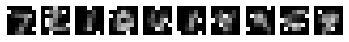

Predicted


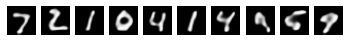

Original


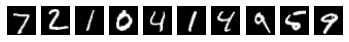

In [16]:
# Predict on the test set, and plot a few examples
y_test_hat = CNN.predict(x_test[:10])

print("Noisy")
for ind, img in enumerate(x_test[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.show()

print("Predicted")
for ind, img in enumerate(y_test_hat):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.show()

print("Original")
for ind, img in enumerate(y_test[:10]):
  plt.subplot(1, 10, ind+1)
  plt.imshow(img[:,:,0], cmap='gray')
  plt.axis('off')
plt.show()

In [15]:
# == Q6 ==
# ¿Qué problema está resolviendo esta red?

# == Q7 ==
# ¿Puedes mejorar el modelo para aumentar la exactitud a más de 0.95?
# Reporta el modelo resultante.